# Run torsion scans

In [46]:
import os
import pickle
import numpy as np
from openmmtools.integrators import LangevinIntegrator
from openmmtools.states import ThermodynamicState, CompoundThermodynamicState, SamplerState
from perses.annihilation.lambda_protocol import RelativeAlchemicalState, LambdaProtocol, AlchemicalState
from openmmtools.alchemy import AbsoluteAlchemicalFactory, AlchemicalRegion, AlchemicalState
from simtk import openmm, unit
from tqdm import tqdm
import mdtraj as md
from openmmtools.mcmc import MCDihedralRotationMove, LangevinSplittingDynamicsMove
import math
from matplotlib import pyplot as plt
import logging
import copy
from openmmtools import cache
import scipy
from perses.tests.test_topology_proposal import generate_atp, generate_dipeptide_top_pos_sys

logger = logging.getLogger()
logger.setLevel(logging.INFO)


In [38]:
def run_md(htf, endstate, repartitioned=False):

    system = htf.hybrid_system
    positions = htf.hybrid_positions
    temperature = 300 * unit.kelvin
    collision_rate = 1 / unit.picosecond
    timestep = 4.0 * unit.femtosecond
    platform_name = 'CUDA'
    nsteps = 100
    
    if not repartitioned:
        print("Vanilla htf -- creating thermostate")
        # Create CompoundThermodynamicState at the appropriate endstate
        lambda_alchemical_state = RelativeAlchemicalState.from_system(system)
        lambda_protocol = LambdaProtocol(functions = 'default')
        lambda_alchemical_state.set_alchemical_parameters(endstate, lambda_protocol)
        thermodynamic_state = CompoundThermodynamicState(ThermodynamicState(system, temperature=temperature), composable_states=[lambda_alchemical_state])
    else:  
        print("Repartioned htf -- creating alchemical region first, then thermostate")
        # Alchemify the hybrid system
        atoms_to_alchemify = list(htf._atom_classes['unique_new_atoms']) + list(htf._atom_classes['unique_old_atoms'])

        alch_factory = AbsoluteAlchemicalFactory(consistent_exceptions=False)
        alchemical_region = AlchemicalRegion(alchemical_atoms=list(atoms_to_alchemify), alchemical_torsions=True)
        alchemical_system = alch_factory.create_alchemical_system(htf.hybrid_system, alchemical_region)
        alchemical_state = AlchemicalState.from_system(alchemical_system)
        alchemical_state.set_alchemical_parameters(endstate)
        thermodynamic_state = CompoundThermodynamicState(ThermodynamicState(alchemical_system, temperature=temperature), composable_states=[alchemical_state])

    # Set up integrator
    integrator = LangevinIntegrator(temperature, collision_rate, timestep)

    # Set up context
    platform = openmm.Platform.getPlatformByName(platform_name)
    if platform_name in ['CUDA', 'OpenCL']:
        platform.setPropertyDefaultValue('Precision', 'mixed')
    if platform_name in ['CUDA']:
        platform.setPropertyDefaultValue('DeterministicForces', 'true')
        
    context = thermodynamic_state.create_context(integrator, platform=platform)
#     context, integrator = cache.global_context_cache.get_context(thermodynamic_state, integrator)
    p = context.getParameters()
    for x in p:
        print(x, p[x])
    
#     context = openmm.Context(system, integrator, platform)
    context.setPeriodicBoxVectors(*system.getDefaultPeriodicBoxVectors())
    context.setPositions(positions)
    context.setVelocitiesToTemperature(temperature)
    print(thermodynamic_state.reduced_potential(context))
    
    md.Trajectory(np.array(htf.old_positions(positions)), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("nan_before_minimize.pdb")

    # Minimize
    openmm.LocalEnergyMinimizer.minimize(context)

    md.Trajectory(np.array(htf.old_positions(positions)), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("nan_after_minimize.pdb")
    
    # Run equilibration
    for step in tqdm(range(nsteps)):
        integrator.step(1)
#         md.Trajectory(np.array(htf.old_positions(positions)), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("nan_after_md.pdb")
    
    print(thermodynamic_state.reduced_potential(context))
    return context, thermodynamic_state

### Sub-class MCDihedralRotationMove

In [3]:
# 1) Remove metropolize part in apply()
# 2) Pass -theta to compute_dihedral()

class MCDihedralRotationMove2(MCDihedralRotationMove):
    def rotate_positions(self, initial_positions):
        """Apply rotation to atom_subset positions.
        Parameters
        ----------
        initial_positions : numpy.ndarray simtk.unit.Quantity
            The positions of all atoms in atom_subset.
        Returns
        -------
        rotated_positions : numpy.ndarray simtk.unit.Quantity
            The rotated positions.
        """
        import math
        import copy
        import numpy as np 
        import logging
        logger = logging.getLogger()
        
        old_angle = self.compute_dihedral(initial_positions[:4])

        if self.desired_angle == -np.inf:
            # Choose a random rotation angle
            theta = random.uniform(-math.pi, math.pi)
        else:
            # If desired_angle is specified, determine rotation angle
            if not (self.desired_angle <= math.pi and self.desired_angle >= -math.pi):
                raise Exception("Desired angle must be less than pi and greater than -pi")
            theta = self.desired_angle - old_angle
        logger.info(f"Rotating by {theta} radians")

        # Make a copy of the initial positions
        new_positions = copy.deepcopy(initial_positions)

        # Find the rotation axis using the initial positions
        axis1 = 1
        axis2 = 2
        rotation_axis = (initial_positions[axis1] - initial_positions[axis2]) / initial_positions.unit

        # Calculate the rotation matrix
        rotation_matrix = self.generate_rotation_matrix(rotation_axis, -theta) ## CHANGED theta to negative

        # Apply the rotation matrix to the target atoms
        for atom_index in range(3, len(self.atom_subset)):
            # Find the reduced position (substract out axis)
            reduced_position = (initial_positions[atom_index] - initial_positions[axis2])._value

            # Find the new positions by multiplying by rot matrix
            new_position = np.dot(rotation_matrix, reduced_position) * initial_positions.unit + initial_positions[axis2]

            # Update the new positions
            new_positions[atom_index][0] = new_position[0]
            new_positions[atom_index][1] = new_position[1]
            new_positions[atom_index][2] = new_position[2]
        
        return new_positions
    def apply(self, thermodynamic_state, sampler_state):
        """Apply a metropolized move to the sampler state.
        Total number of acceptances and proposed move are updated.
        Parameters
        ----------
        thermodynamic_state : openmmtools.states.ThermodynamicState
           The thermodynamic state to use to apply the move.
        sampler_state : openmmtools.states.SamplerState
           The initial sampler state to apply the move to. This is modified.
        """
#         from openmmtools import cache
        import copy
#         timer = Timer()
#         benchmark_id = 'Applying {}'.format(self.__class__.__name__ )
#         timer.start(benchmark_id)

        # Check if we have to use the global cache.
        if self.context_cache is None:
            context_cache = cache.global_context_cache
        else:
            context_cache = self.context_cache

        # Create context, any integrator works.
        context, unused_integrator = context_cache.get_context(thermodynamic_state)
        
        # Compute initial energy. We don't need to set velocities to compute the potential.
        # TODO assume sampler_state.potential_energy is the correct potential if not None?
        sampler_state.apply_to_context(context, ignore_velocities=True)
        initial_energy = thermodynamic_state.reduced_potential(context)

        # Handle default and weird cases for atom_subset.
        if self.atom_subset is None:
            atom_subset = slice(None)
        elif not isinstance(self.atom_subset, slice) and len(self.atom_subset) == 1:
            # Slice so that initial_positions (below) will have a 2D shape.
            atom_subset = slice(self.atom_subset[0], self.atom_subset[0]+1)
        else:
            atom_subset = self.atom_subset

        # Store initial positions of the atoms that are moved.
        # We'll use this also to recover in case the move is rejected.
        if isinstance(atom_subset, slice):
            # Numpy array when sliced return a view, they are not copied.
            initial_positions = copy.deepcopy(sampler_state.positions[atom_subset])
        else:
            # This automatically creates a copy.
            initial_positions = sampler_state.positions[atom_subset]

        # Propose perturbed positions. Modifying the reference changes the sampler state.
        proposed_positions = self._propose_positions(initial_positions)

        # Compute the energy of the proposed positions.
        sampler_state.positions[atom_subset] = proposed_positions
        sampler_state.apply_to_context(context, ignore_velocities=True)
        proposed_energy = thermodynamic_state.reduced_potential(context)

#         # Accept or reject with Metropolis criteria.
#         delta_energy = proposed_energy - initial_energy
#         if (not np.isnan(proposed_energy) and
#                 (delta_energy <= 0.0 or np.random.rand() < np.exp(-delta_energy))):
#             self.n_accepted += 1
#         else:
#             # Restore original positions.
#             sampler_state.positions[atom_subset] = initial_positions
#         self.n_proposed += 1

#         # Print timing information.
#         timer.stop(benchmark_id)
#         #timer.report_timing()
        
        return proposed_energy, sampler_state.positions

### Define function for computing potential components

In [58]:
from openmmtools.constants import kB
temperature = 300.0 * unit.kelvin
kT = kB * temperature
beta = 1.0/kT
def compute_potential_components(context, beta = beta):
    """
    Compute potential energy, raising an exception if it is not finite.
    Parameters
    ----------
    context : simtk.openmm.Context
        The context from which to extract, System, parameters, and positions.
    """
    # Make a deep copy of the system.
    import copy

#     from perses.dispersed.utils import configure_platform
#     platform = configure_platform(platform.getName(), fallback_platform_name='Reference', precision='double')
    platform = openmm.Platform.getPlatformByName('CUDA')
    platform.setPropertyDefaultValue('CudaPrecision', 'mixed')
    platform.setPropertyDefaultValue('DeterministicForces', 'true')

    system = context.getSystem()
    system = copy.deepcopy(system)
    # Get positions.
    positions = context.getState(getPositions=True).getPositions(asNumpy=True)
    # Get Parameters
    parameters = context.getParameters()
    # Segregate forces.
    for index in range(system.getNumForces()):
        force = system.getForce(index)
        force.setForceGroup(index)
    # Create new Context.
    integrator = openmm.VerletIntegrator(1.0 * unit.femtoseconds)
    context = openmm.Context(system, integrator, platform)
    context.setPositions(positions)
    for (parameter, value) in parameters.items():
        context.setParameter(parameter, value)
    energy_components = list()
    for index in range(system.getNumForces()):
        force = system.getForce(index)
        forcename = force.__class__.__name__
        groups = 1<<index
        potential = beta * context.getState(getEnergy=True, groups=groups).getPotentialEnergy()
        energy_components.append((forcename, potential))
    del context, integrator
    return energy_components

### Define run torsion scan function

In [55]:
def run_torsion_scan(htf, endstate, is_old, hybrid_indices, vanilla_indices, other_indices, repartitioned=False):
    """
    hybrid_indices : list of int
        indices of the dihedral atoms from the hybrid system
    vanilla_indices : list of int
        indices of the dihedral atoms from the vanilla (old or new) system
    other_indices : list of int
        indices of the non-dihedral sidechain atoms to be rotated, from the hybrid system
    """
    
#     d_masses = {}
#     # Set particle masses to 0
#     for index in hybrid_indices:
#         d_masses[index] = htf.hybrid_system.getParticleMass(index)
#         htf.hybrid_system.setParticleMass(index, 0.0)
    
#     # Turn off constraints involving massless particles
#     for i in reversed(range(htf.hybrid_system.getNumConstraints())):
#         p1, p2, d = htf.hybrid_system.getConstraintParameters(i)
#         if p1 in hybrid_indices or p2 in hybrid_indices:
#             if htf.hybrid_system.getParticleMass(p1) == 0*unit.amu or htf.hybrid_system.getParticleMass(p2) == 0*unit.amu:
#                 htf.hybrid_system.removeConstraint(i)
    
    # Run MD
    context, thermodynamic_state = run_md(htf, endstate, repartitioned=repartitioned)
    
    # Create sampler state
    sampler_state = SamplerState.from_context(context)
    
    # Compute current dihedral
    if is_old:
        dihedral = md.compute_dihedrals(md.Trajectory(np.array(htf.old_positions(htf.hybrid_positions)), 
                                                      md.Topology.from_openmm(htf._topology_proposal.old_topology)), 
                                        np.array([vanilla_indices]))[0][0]
    else:
        dihedral = md.compute_dihedrals(md.Trajectory(np.array(htf.new_positions(htf.hybrid_positions)), 
                                                      md.Topology.from_openmm(htf._topology_proposal.new_topology)), 
                                        np.array([vanilla_indices]))[0][0]
    print(dihedral)
    
    # Run scan
    d = {} # key : angle, value : energy
    new_dihedral = dihedral + 0.262
    positions_all = []
    for i in range(25):
        # Add correction if the angle is no longer in the domain of [-pi, pi]
        if new_dihedral > math.pi: 
            new_dihedral = -math.pi + (new_dihedral - math.pi)
        elif new_dihedral < -math.pi:
            new_dihedral = math.pi + (new_dihedral + math.pi)
        
        print(thermodynamic_state.reduced_potential(context))
        
        # Apply rotation move
        move = MCDihedralRotationMove2(hybrid_indices + other_indices, desired_angle=new_dihedral) # Rotate the sidechain by 15 degrees
        move.apply(thermodynamic_state, sampler_state)
        
        sampler_state.apply_to_context(context)
#         openmm.LocalEnergyMinimizer.minimize(context)
        energy = thermodynamic_state.reduced_potential(context)
        energies = [energy]
        
        energy_comps = compute_potential_components(context)
        for name, force in energy_comps:
            print("\t\t\t{}: {}".format(name, force))
        print(f'added forces:{sum([energy for name, energy in energy_comps])}')
        
#         sampler_state.update_from_context(context)
        
#         # Apply relaxation move 3x
#         energies = []
#         for i in range(3):
#             relax_move = LangevinSplittingDynamicsMove(timestep=2.0*unit.femtoseconds, collision_rate=1.0/unit.picoseconds, n_steps=10000)
#             relax_move.apply(thermodynamic_state, sampler_state)
#             sampler_state.apply_to_context(context)
#             energy = thermodynamic_state.reduced_potential(context)
#             energies.append(energy)
#             positions = sampler_state.positions

    
        d[new_dihedral] = (np.mean(energies), scipy.stats.sem(energies))
        
#         if is_old:
#             positions_all.append(htf.old_positions(positions)/unit.nanometer) # get last positions from last relaxtion
#         else:
#             positions_all.append(htf.new_positions(positions)/unit.nanometer) # get last positions from last relaxtion
        
        # Increment dihedral angle by 15 degrees
        new_dihedral += 0.262
    
    print(f"raw d: {d}")
        
#     # Write out pdb of positions
#     if is_old:
#         md.Trajectory(np.array(positions_all), md.Topology.from_openmm(htf._topology_proposal.old_topology)).save("traj.pdb")
#     else:
#         md.Trajectory(np.array(positions_all), md.Topology.from_openmm(htf._topology_proposal.new_topology)).save("traj.pdb")
        
    # Plot scan data
    minimum = min([val[0] for val in list(d.values())])
    print(f"min: {minimum}")
    d_corrected = {}
    for k, v in d.items():
        d_corrected[k] = (v[0] - minimum, v[1])
    print(f"d corrected: {d_corrected}")
    plt.errorbar(list(d_corrected.keys()), [mean for mean, stderr in list(d_corrected.values())], yerr=[stderr for mean, stderr in list(d_corrected.values())], fmt='o')
    plt.show()
    
#     # Set masses back to normal
#     for index in hybrid_indices:
#         thermodynamic_state.system.setParticleMass(index, d_masses[index])
#     thermodynamic_state.apply_to_context(context)
    
    return d_corrected
    

# rp_list = []
# for (state_name, state, pos, box_vectors) in attrib_list:
#     integrator = openmm.VerletIntegrator(1.0 * unit.femtoseconds)
#     context = state.create_context(integrator, platform)
#     samplerstate = states.SamplerState(positions = pos, box_vectors = box_vectors)
#     samplerstate.apply_to_context(context)
#     rp = state.reduced_potential(context)
#     rp_list.append(rp)
#     energy_comps = compute_potential_components(context)
#     for name, force in energy_comps:
#         print("\t\t\t{}: {}".format(name, force))
#     _logger.debug(f'added forces:{sum([energy for name, energy in energy_comps])}')
#     _logger.debug(f'rp: {rp}')
#     if trajectory_directory is not None:
#         _logger.info(f'Saving {state_name} state xml to {trajectory_directory}/{state_name}-state.gz')
#         state = context.getState(getPositions=True, getVelocities=True, getForces=True, getEnergy=True, getParameters=True)
#         data.serialize(state,f'{trajectory_directory}-{state_name}-state.gz')
#     del context, integrator

In [5]:
torsion_scans = []

### Generate torsion scans for the vanilla htf: THR->ALA lambda = 0

In [9]:
from simtk.openmm import app, unit
from openmmforcefields.generators import SystemGenerator


In [18]:
# Read in htf for 10 ns eq, 2 ns neq T42A
with open("/data/chodera/zhangi/perses_benchmark/neq/8/11/11_apo.pickle", "rb") as f:
    htf = pickle.load(f)

In [66]:
# Read in htf capped amino acid THR -> ALA to check this code is right
# with open("/data/chodera/zhangi/perses_benchmark/neq/7/40/40_vacuum.pickle", "rb") as f:
#     htf = pickle.load(f)

# ALA -> THR
with open("/data/chodera/zhangi/perses_benchmark/neq/7/39/39_vacuum.pickle", "rb") as f:
    htf = pickle.load(f)

#### Look at hybrid topology to determine indices

In [67]:
for atom in htf.hybrid_topology.atoms:
    print(atom, atom.index)

ACE1-H1 0
ACE1-CH3 1
ACE1-H2 2
ACE1-H3 3
ACE1-C 4
ACE1-O 5
ALA2-N 6
ALA2-H 7
ALA2-CA 8
ALA2-HA 9
ALA2-CB 10
ALA2-HB1 11
ALA2-HB2 12
ALA2-HB3 13
ALA2-C 14
ALA2-O 15
ALA2-CB 22
ALA2-HB 23
ALA2-CG2 24
ALA2-HG21 25
ALA2-HG22 26
ALA2-HG23 27
ALA2-OG1 28
ALA2-HG1 29
NME3-N 16
NME3-H 17
NME3-C 18
NME3-H1 19
NME3-H2 20
NME3-H3 21


In [68]:
for atom in htf._topology_proposal.old_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (ALA)> 6
<Atom 7 (H) of chain 0 residue 1 (ALA)> 7
<Atom 8 (CA) of chain 0 residue 1 (ALA)> 8
<Atom 9 (HA) of chain 0 residue 1 (ALA)> 9
<Atom 10 (CB) of chain 0 residue 1 (ALA)> 10
<Atom 11 (HB1) of chain 0 residue 1 (ALA)> 11
<Atom 12 (HB2) of chain 0 residue 1 (ALA)> 12
<Atom 13 (HB3) of chain 0 residue 1 (ALA)> 13
<Atom 14 (C) of chain 0 residue 1 (ALA)> 14
<Atom 15 (O) of chain 0 residue 1 (ALA)> 15
<Atom 16 (N) of chain 0 residue 2 (NME)> 16
<Atom 17 (H) of chain 0 residue 2 (NME)> 17
<Atom 18 (C) of chain 0 residue 2 (NME)> 18
<Atom 19 (H1) of chain 0 residue 2 (NME)> 19
<Atom 20 (H2) of chain 0 residue 2 (NME)> 20
<Atom 21 (H3) of chain 0 residue 2 (NME)> 21


In [69]:
for atom in htf._topology_proposal.new_topology.atoms():
    print(atom, atom.index)

<Atom 0 (H1) of chain 0 residue 0 (ACE)> 0
<Atom 1 (CH3) of chain 0 residue 0 (ACE)> 1
<Atom 2 (H2) of chain 0 residue 0 (ACE)> 2
<Atom 3 (H3) of chain 0 residue 0 (ACE)> 3
<Atom 4 (C) of chain 0 residue 0 (ACE)> 4
<Atom 5 (O) of chain 0 residue 0 (ACE)> 5
<Atom 6 (N) of chain 0 residue 1 (THR)> 6
<Atom 7 (H) of chain 0 residue 1 (THR)> 7
<Atom 8 (CA) of chain 0 residue 1 (THR)> 8
<Atom 9 (HA) of chain 0 residue 1 (THR)> 9
<Atom 10 (CB) of chain 0 residue 1 (THR)> 10
<Atom 11 (C) of chain 0 residue 1 (THR)> 11
<Atom 12 (O) of chain 0 residue 1 (THR)> 12
<Atom 13 (HB) of chain 0 residue 1 (THR)> 13
<Atom 14 (CG2) of chain 0 residue 1 (THR)> 14
<Atom 15 (HG21) of chain 0 residue 1 (THR)> 15
<Atom 16 (HG22) of chain 0 residue 1 (THR)> 16
<Atom 17 (HG23) of chain 0 residue 1 (THR)> 17
<Atom 18 (OG1) of chain 0 residue 1 (THR)> 18
<Atom 19 (HG1) of chain 0 residue 1 (THR)> 19
<Atom 20 (N) of chain 0 residue 2 (NME)> 20
<Atom 21 (H) of chain 0 residue 2 (NME)> 21
<Atom 22 (C) of chain 0 resi

Vanilla htf -- creating thermostate
3844.7787020008177


100%|██████████| 10000/10000 [00:08<00:00, 1194.73it/s]
INFO:root:Rotating by 0.17552191203601164 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2620000000000011 radians
INFO:root:Rotating by 0.2619999999999971 radians
INFO:root:Rotating by 0.26199999999999823 radians
INFO:root:Rotating by 0.26199999999999823 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by -6.0211853071795876 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26199999999999735 radians
INFO:root:Rotating by 0.26200000000000134 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.26200000000000223 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.2620000000000031 radians
INFO:root:Rotating by 0.26199999999999823 radians
INFO:root:Rotating by 0.2619999999999991 radians
INFO:root:Rotating by 0.2620000000000017 radians
INFO:root:Rotating by 0.261

1.1298606
-78500.63307665451
-78484.41816304052
-78297.35768839199
-75929.560557651
-72557.40479516593
-76856.18056738483
-75914.22049601041
-66287.10665984034
-45268.74326474599
601891412.5925299
9141647.992487187
-76657.56951839442
-77773.28319890646
-77741.09239050187
-77645.03711112247
-77521.29614787332
-77436.1676640786
-76824.67397128165
-76122.2293046744
-77075.75857797072
-77825.69128063798
-77972.58592266208


INFO:root:Rotating by 0.2620000000000001 radians
INFO:root:Rotating by 0.26200000000000034 radians
INFO:root:Rotating by 0.2619999999999991 radians


-78166.20683035474
-78372.14898796912
-78491.13324702399
raw d: {1.3918606395721436: (-78484.41816304052, nan), 1.6538606395721436: (-78297.35768839199, nan), 1.9158606395721436: (-75929.560557651, nan), 2.1778606395721436: (-72557.40479516593, nan), 2.4398606395721436: (-76856.18056738483, nan), 2.7018606395721436: (-75914.22049601041, nan), 2.9638606395721436: (-66287.10665984034, nan), -3.0573246676074426: (-45268.74326474599, nan), -2.7953246676074426: (601891412.5925299, nan), -2.5333246676074426: (9141647.992487187, nan), -2.2713246676074426: (-76657.56951839442, nan), -2.0093246676074425: (-77773.28319890646, nan), -1.7473246676074425: (-77741.09239050187, nan), -1.4853246676074425: (-77645.03711112247, nan), -1.2233246676074425: (-77521.29614787332, nan), -0.9613246676074425: (-77436.1676640786, nan), -0.6993246676074425: (-76824.67397128165, nan), -0.4373246676074425: (-76122.2293046744, nan), -0.17532466760744247: (-77075.75857797072, nan), 0.08667533239255754: (-77825.691280

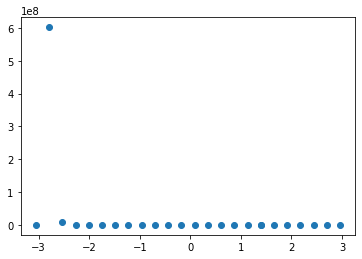

{1.3918606395721436: (6.715083983464865, nan),
 1.6538606395721436: (193.77555863199814, nan),
 1.9158606395721436: (2561.572689372988, nan),
 2.1778606395721436: (5933.728451858056, nan),
 2.4398606395721436: (1634.9526796391583, nan),
 2.7018606395721436: (2576.912751013573, nan),
 2.9638606395721436: (12204.026587183645, nan),
 -3.0573246676074426: (33222.389982278, nan),
 -2.7953246676074426: (601969903.7257769, nan),
 -2.5333246676074426: (9220139.12573421, nan),
 -2.2713246676074426: (1833.5637286295678, nan),
 -2.0093246676074425: (717.8500481175288, nan),
 -1.7473246676074425: (750.0408565221151, nan),
 -1.4853246676074425: (846.09613590152, nan),
 -1.2233246676074425: (969.8370991506672, nan),
 -0.9613246676074425: (1054.965582945384, nan),
 -0.6993246676074425: (1666.459275742338, nan),
 -0.4373246676074425: (2368.903942349585, nan),
 -0.17532466760744247: (1415.3746690532716, nan),
 0.08667533239255754: (665.4419663860026, nan),
 0.34867533239255755: (518.5473243619053, nan)

In [11]:
# THR->ALA -- THR at lambda = 0
run_torsion_scan(htf, 0, True, [669, 670, 673, 674], [669, 670, 673, 674], [675, 676, 677, 678, 679, 680, 681, 682], repartitioned=False)

Vanilla htf -- creating thermostate


  5%|▌         | 521/10000 [00:00<00:01, 5208.83it/s]

lambda_angles 0.0
lambda_bonds 0.0
lambda_electrostatics_core 0.0
lambda_electrostatics_delete 0.0
lambda_electrostatics_insert 0.0
lambda_sterics_core 0.0
lambda_sterics_delete 0.0
lambda_sterics_insert 0.0
lambda_torsions 0.0
softcore_alpha 0.85
-16.0836029288311


100%|██████████| 10000/10000 [00:01<00:00, 5909.75it/s]
INFO:root:Rotating by 2.8980261646914713 radians


-1.3284695345934885
2.4310682
-1.3284695345934885


INFO:root:Rotating by 0.262 radians


			CustomBondForce: 7836.842209369503
			HarmonicBondForce: 1.4538223944469333
			CustomAngleForce: 690.6627242602764
			HarmonicAngleForce: 520.79586212926
			CustomTorsionForce: 9.63471507341536
			PeriodicTorsionForce: 15.621033720716886
			NonbondedForce: 799.1420226140801
			CustomNonbondedForce: 150.56809170267871
			CustomBondForce: 11.289245895458182
added forces:10036.009727159835
10036.009727159835


INFO:root:Rotating by -6.021185307179586 radians


			CustomBondForce: 8195.890805091318
			HarmonicBondForce: 1.4538274125946857
			CustomAngleForce: 694.4068903306696
			HarmonicAngleForce: 551.5786603412548
			CustomTorsionForce: 9.445780346915926
			PeriodicTorsionForce: 17.994115420885286
			NonbondedForce: 6677.194055998017
			CustomNonbondedForce: 703.8174699069892
			CustomBondForce: 11.89207120575017
added forces:16863.673676054394
16863.673676054397


INFO:root:Rotating by 0.26199999999999823 radians


			CustomBondForce: 8198.617272138556
			HarmonicBondForce: 1.4538123581514288
			CustomAngleForce: 722.1146180869703
			HarmonicAngleForce: 557.2566892658424
			CustomTorsionForce: 9.054574921331998
			PeriodicTorsionForce: 20.98987649060775
			NonbondedForce: 40325.94759116052
			CustomNonbondedForce: 246824.19132688412
			CustomBondForce: 12.53487337504715
added forces:296672.1606346811
296672.1606346812


INFO:root:Rotating by 0.2620000000000009 radians


			CustomBondForce: 7844.792238397144
			HarmonicBondForce: 1.4538073400036766
			CustomAngleForce: 769.2977346861467
			HarmonicAngleForce: 567.8492179319044
			CustomTorsionForce: 8.646642124181948
			PeriodicTorsionForce: 24.923822960769126
			NonbondedForce: 68261.40835037135
			CustomNonbondedForce: 9045703306.907503
			CustomBondForce: 13.211010669735519
added forces:9045780798.490328
9045780798.490326


INFO:root:Rotating by 0.26200000000000045 radians


			CustomBondForce: 7165.01462475838
			HarmonicBondForce: 1.4538274125946857
			CustomAngleForce: 814.0401019190731
			HarmonicAngleForce: 590.0103009186261
			CustomTorsionForce: 8.436584852168442
			PeriodicTorsionForce: 28.203300756237937
			NonbondedForce: 71011.50697860135
			CustomNonbondedForce: 5099294.436147277
			CustomBondForce: 13.958299373357555
added forces:5178927.060165869
5178927.060165869


INFO:root:Rotating by 0.262 radians


			CustomBondForce: 6218.378349607553
			HarmonicBondForce: 1.4538274125946857
			CustomAngleForce: 740.082989487279
			HarmonicAngleForce: 612.592701207425
			CustomTorsionForce: 8.557987599530437
			PeriodicTorsionForce: 26.457426302207352
			NonbondedForce: 269370.0191953918
			CustomNonbondedForce: 1028278400.4071159
			CustomBondForce: 14.871982209743562
added forces:1028555392.8215752
1028555392.8215754


INFO:root:Rotating by 0.26200000000000045 radians


			CustomBondForce: 5087.933103935034
			HarmonicBondForce: 1.4538324785343213
			CustomAngleForce: 655.2021106290591
			HarmonicAngleForce: 513.7231030123386
			CustomTorsionForce: 8.981088287471882
			PeriodicTorsionForce: 28.058190038305476
			NonbondedForce: 461160.33305902896
			CustomNonbondedForce: 254053028.4441164
			CustomBondForce: 16.041077774586995
added forces:254520500.16968158
254520500.1696816


INFO:root:Rotating by 0.262 radians


			CustomBondForce: 3874.113591620602
			HarmonicBondForce: 1.4538123581514288
			CustomAngleForce: 580.9030209439464
			HarmonicAngleForce: 414.27062187106105
			CustomTorsionForce: 9.507910243326286
			PeriodicTorsionForce: 27.478165428298194
			NonbondedForce: 125405.93396061531
			CustomNonbondedForce: 45805640650694.266
			CustomBondForce: 17.3295721839512
added forces:45805640781025.26
45805640781025.25


INFO:root:Rotating by 0.26200000000000045 radians


			CustomBondForce: 2686.3777157325235
			HarmonicBondForce: 1.4538123581514288
			CustomAngleForce: 508.64994103471713
			HarmonicAngleForce: 326.6014929818887
			CustomTorsionForce: 9.860120915186211
			PeriodicTorsionForce: 25.3242865895555
			NonbondedForce: 13038.164329909254
			CustomNonbondedForce: 2300858351.9015203
			CustomBondForce: 18.121354844225404
added forces:2300874966.454575
2300874966.4545746


INFO:root:Rotating by 0.2619999999999998 radians


			CustomBondForce: 1633.0826729586545
			HarmonicBondForce: 1.4538223944469333
			CustomAngleForce: 426.0875925271928
			HarmonicAngleForce: 236.49622358172928
			CustomTorsionForce: 9.82554639093581
			PeriodicTorsionForce: 22.46033356245414
			NonbondedForce: 1237.642413964241
			CustomNonbondedForce: 118936.07130988786
			CustomBondForce: 17.6335479655934
added forces:122520.75346323311
122520.7534632331


INFO:root:Rotating by 0.26199999999999923 radians


			CustomBondForce: 808.9642689067693
			HarmonicBondForce: 1.4538274125946857
			CustomAngleForce: 326.9944826445306
			HarmonicAngleForce: 145.61976546201228
			CustomTorsionForce: 9.391095028019684
			PeriodicTorsionForce: 19.272646859441984
			NonbondedForce: 137.90015766978797
			CustomNonbondedForce: 798.1952848007504
			CustomBondForce: 15.909589112917686
added forces:2263.7011178968246
2263.7011178968246


INFO:root:Rotating by 0.262 radians


			CustomBondForce: 277.6125746820408
			HarmonicBondForce: 1.4538274125946857
			CustomAngleForce: 211.25081038041867
			HarmonicAngleForce: 69.98450681026706
			CustomTorsionForce: 8.783344293696615
			PeriodicTorsionForce: 15.600397590221727
			NonbondedForce: -5.769007776064634
			CustomNonbondedForce: 50.52532968191496
			CustomBondForce: 13.911041134172134
added forces:643.352824209262
643.3528242092619


INFO:root:Rotating by 0.26199999999999973 radians


			CustomBondForce: 42.46308619531456
			HarmonicBondForce: 1.4538274125946857
			CustomAngleForce: 85.62080267430628
			HarmonicAngleForce: 23.718112348029248
			CustomTorsionForce: 8.368592113723823
			PeriodicTorsionForce: 11.3800472419065
			NonbondedForce: -51.993454352418105
			CustomNonbondedForce: 9.598687408330095
			CustomBondForce: 12.443567364232562
added forces:143.05326840601967
143.05326840601964


INFO:root:Rotating by 0.2620000000000007 radians


			CustomBondForce: 5.790883208341547
			HarmonicBondForce: 1.4538274125946857
			CustomAngleForce: 16.730426836542886
			HarmonicAngleForce: 11.401943105546081
			CustomTorsionForce: 8.430991271845246
			PeriodicTorsionForce: 8.13505400616641
			NonbondedForce: -64.10124390154728
			CustomNonbondedForce: -0.1968952212331179
			CustomBondForce: 11.656988762136878
added forces:-0.6980245196066583
-0.6980245196066641


INFO:root:Rotating by 0.26199999999999934 radians


			CustomBondForce: 5.777981816312809
			HarmonicBondForce: 1.453817376299181
			CustomAngleForce: 174.38882090301254
			HarmonicAngleForce: 28.957173657489115
			CustomTorsionForce: 8.946574010864436
			PeriodicTorsionForce: 13.186608657564946
			NonbondedForce: -66.2669503486473
			CustomNonbondedForce: -2.3391541868220016
			CustomBondForce: 11.284076916522043
added forces:175.38894880259576
175.38894880259576


INFO:root:Rotating by 0.2620000000000005 radians


			CustomBondForce: 42.824133909002036
			HarmonicBondForce: 1.4538274125946857
			CustomAngleForce: 431.8686747423991
			HarmonicAngleForce: 77.64653297887195
			CustomTorsionForce: 9.551267864315895
			PeriodicTorsionForce: 28.939948835990407
			NonbondedForce: -65.55239894174777
			CustomNonbondedForce: -2.617218993144692
			CustomBondForce: 10.965637590468825
added forces:535.0804053987505
535.0804053987504


INFO:root:Rotating by 0.2619999999999998 radians


			CustomBondForce: 278.8510785155733
			HarmonicBondForce: 1.4538274125946857
			CustomAngleForce: 528.0508088815744
			HarmonicAngleForce: 152.69732931800488
			CustomTorsionForce: 9.81312081191076
			PeriodicTorsionForce: 22.595263328588036
			NonbondedForce: -55.4085438608849
			CustomNonbondedForce: -2.572450226938385
			CustomBondForce: 10.541561905168917
added forces:946.0219960855918
946.0219960855919


INFO:root:Rotating by 0.26200000000000057 radians


			CustomBondForce: 811.2120901790267
			HarmonicBondForce: 1.4538274125946857
			CustomAngleForce: 619.3610279716216
			HarmonicAngleForce: 244.12565498692982
			CustomTorsionForce: 9.59772942475376
			PeriodicTorsionForce: 21.333651617638576
			NonbondedForce: 8.174278039992318
			CustomNonbondedForce: -2.4250864423407372
			CustomBondForce: 10.111233655561563
added forces:1722.9444068457783
1722.9444068457783


INFO:root:Rotating by 0.26199999999999957 radians


			CustomBondForce: 1636.2103134204292
			HarmonicBondForce: 1.4538274125946857
			CustomAngleForce: 712.9672888518552
			HarmonicAngleForce: 348.46260750913115
			CustomTorsionForce: 9.138693457789714
			PeriodicTorsionForce: 20.174391786674192
			NonbondedForce: 247.74893346940027
			CustomNonbondedForce: -2.0795960676908027
			CustomBondForce: 9.81801338947651
added forces:2983.89447322966
2983.89447322966


INFO:root:Rotating by 0.262 radians


			CustomBondForce: 2690.1129103710596
			HarmonicBondForce: 1.4538223944469333
			CustomAngleForce: 802.6374624332866
			HarmonicAngleForce: 466.8701268168112
			CustomTorsionForce: 8.775744249185946
			PeriodicTorsionForce: 18.700478676519786
			NonbondedForce: 520.833999242603
			CustomNonbondedForce: -1.2480345843480738
			CustomBondForce: 9.708339810883407
added forces:4517.844849410449
4517.844849410449


INFO:root:Rotating by 0.2619999999999998 radians


			CustomBondForce: 3878.1163826470947
			HarmonicBondForce: 1.453817376299181
			CustomAngleForce: 866.0929941715253
			HarmonicAngleForce: 534.1532510995859
			CustomTorsionForce: 8.701424714811182
			PeriodicTorsionForce: 15.381080583739934
			NonbondedForce: 356.5037768354794
			CustomNonbondedForce: 0.6880480864288507
			CustomBondForce: 9.767777476998658
added forces:5670.858552991964
5670.858552991964


INFO:root:Rotating by 0.2619999999999998 radians


			CustomBondForce: 5091.839978001753
			HarmonicBondForce: 1.4538223944469333
			CustomAngleForce: 836.2982096545408
			HarmonicAngleForce: 583.8075840981124
			CustomTorsionForce: 8.908798588152093
			PeriodicTorsionForce: 12.552345398539845
			NonbondedForce: 226.99273099298972
			CustomNonbondedForce: 5.237987176800362
			CustomBondForce: 9.974592407572105
added forces:6777.066048712909
6777.066048712907


INFO:root:Rotating by 0.262 radians


			CustomBondForce: 6221.838523654896
			HarmonicBondForce: 1.4538274125946857
			CustomAngleForce: 763.9631088911315
			HarmonicAngleForce: 533.4520564517536
			CustomTorsionForce: 9.256515539800118
			PeriodicTorsionForce: 12.670044018247145
			NonbondedForce: 286.7193526178215
			CustomNonbondedForce: 16.601479863880623
			CustomBondForce: 10.311325749695353
added forces:7856.266234199819
7856.26623419982


INFO:root:Rotating by 0.262 radians


			CustomBondForce: 7167.722325056132
			HarmonicBondForce: 1.453817376299181
			CustomAngleForce: 713.4573941282205
			HarmonicAngleForce: 510.2996988273292
			CustomTorsionForce: 9.552233744252485
			PeriodicTorsionForce: 13.858802723288022
			NonbondedForce: 286.16090883377615
			CustomNonbondedForce: 48.41036905103096
			CustomBondForce: 10.760317637798604
added forces:8761.675867378126
8761.675867378126
			CustomBondForce: 7846.514096978753
			HarmonicBondForce: 1.4538274125946857
			CustomAngleForce: 690.4915201613908
			HarmonicAngleForce: 521.270253103382
			CustomTorsionForce: 9.633715721238467
			PeriodicTorsionForce: 15.659326202584918
			NonbondedForce: 827.6872947200321
			CustomNonbondedForce: 154.04481029391323
			CustomBondForce: 11.299823003914769
added forces:10078.054667597804
raw d: {2.693068181991577: (10036.009727159835, nan), 2.955068181991577: (16863.673676054397, nan), -3.066117125188009: (296672.1606346812, nan), -2.804117125188009: (9045780798.490326, nan), -

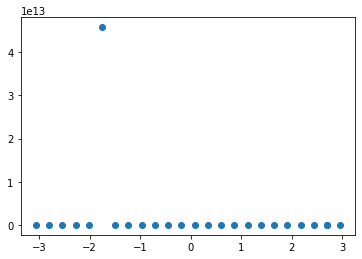

{2.693068181991577: (10036.707751679442, nan),
 2.955068181991577: (16864.371700574004, nan),
 -3.066117125188009: (296672.8586592008, nan),
 -2.804117125188009: (9045780799.18835, nan),
 -2.542117125188009: (5178927.758190389, nan),
 -2.280117125188009: (1028555393.5195999, nan),
 -2.018117125188009: (254520500.86770612, nan),
 -1.756117125188009: (45805640781025.945, nan),
 -1.494117125188009: (2300874967.1525993, nan),
 -1.232117125188009: (122521.4514877527, nan),
 -0.970117125188009: (2264.3991424164315, nan),
 -0.708117125188009: (644.0508487288686, nan),
 -0.44611712518800895: (143.7512929256263, nan),
 -0.18411712518800893: (0.0, nan),
 0.07788287481199108: (176.08697332220243, nan),
 0.3398828748119911: (535.778429918357, nan),
 0.6018828748119911: (946.7200206051986, nan),
 0.8638828748119911: (1723.642431365385, nan),
 1.1258828748119911: (2984.592497749267, nan),
 1.3878828748119911: (4518.542873930055, nan),
 1.6498828748119911: (5671.55657751157, nan),
 1.9118828748119912

In [71]:
# THR->ALA -- ALA at lambda = 0
# run_torsion_scan(htf, 0, False, [669, 670, 14877, 14878], [669, 670, 673, 676], [677, 678], repartitioned=False)
# run_torsion_scan(htf, 0, False, [6, 8, 26, 27], [6, 8, 10, 13], [14, 15], repartitioned=False)

# ALA -> THR -- THR at lambda = 0
run_torsion_scan(htf, 0, True, [6, 8, 22, 28], [6, 8, 10, 18], [13, 14, 15, 16, 17, 19], repartitioned=False)

### Generate torsion scans for vanilla htf: THR->ALA lambda = 1

In [13]:
from simtk.openmm import app, unit
from openmmforcefields.generators import SystemGenerator


Vanilla htf -- creating thermostate
3901.6160982346796


100%|██████████| 10000/10000 [00:08<00:00, 1198.97it/s]
INFO:root:Rotating by -0.1945450272911875 radians
INFO:root:Rotating by 0.26200000000000134 radians
INFO:root:Rotating by 0.26199999999999835 radians
INFO:root:Rotating by 0.26200000000000273 radians
INFO:root:Rotating by 0.26199999999999946 radians
INFO:root:Rotating by 0.26200000000000406 radians
INFO:root:Rotating by 0.26200000000000334 radians
INFO:root:Rotating by 0.2619999999999978 radians
INFO:root:Rotating by 0.26200000000000145 radians
INFO:root:Rotating by 0.2620000000000009 radians
INFO:root:Rotating by 0.2620000000000009 radians
INFO:root:Rotating by 0.26199999999999934 radians
INFO:root:Rotating by 0.26199999999999957 radians
INFO:root:Rotating by 0.262 radians
INFO:root:Rotating by 0.26200000000000356 radians
INFO:root:Rotating by 0.26200000000000223 radians
INFO:root:Rotating by -6.021185307179586 radians
INFO:root:Rotating by 0.26200000000000045 radians
INFO:root:Rotating by 0.26200000000000534 radians
INFO:root:Ro

-1.276259
-78161.55240543232
-78143.53956560449
-78161.51211713925
-78130.9013360641
-78055.97730627743
-77942.72275574651
-77778.27643322802
-77516.96208952984
-77202.24751902997
-77073.8421539868
-77271.14386766146
-77539.63038356717
-77688.33868119204
-77747.61034179576
-77719.90796498247
-77584.38040705185
-77407.92850434627
-77285.2728143278
-76947.88586299437
-76088.22138213136
-76094.4377792741
-77214.95723135083
-77777.10990581148
-77972.65495431246
-78080.55165299616
raw d: {-1.0142589454650879: (-78143.53956560449, nan), -0.7522589454650879: (-78161.51211713925, nan), -0.49025894546508786: (-78130.9013360641, nan), -0.22825894546508785: (-78055.97730627743, nan), 0.03374105453491216: (-77942.72275574651, nan), 0.2957410545349122: (-77778.27643322802, nan), 0.5577410545349122: (-77516.96208952984, nan), 0.8197410545349122: (-77202.24751902997, nan), 1.0817410545349122: (-77073.8421539868, nan), 1.3437410545349122: (-77271.14386766146, nan), 1.6057410545349122: (-77539.63038356

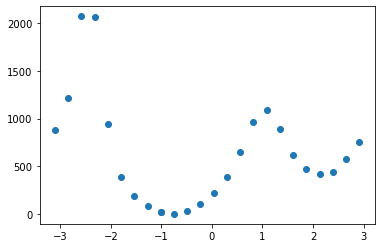

{-1.0142589454650879: (17.972551534767263, nan),
 -0.7522589454650879: (0.0, nan),
 -0.49025894546508786: (30.61078107515641, nan),
 -0.22825894546508785: (105.53481086182, nan),
 0.03374105453491216: (218.78936139274447, nan),
 0.2957410545349122: (383.2356839112326, nan),
 0.5577410545349122: (644.5500276094099, nan),
 0.8197410545349122: (959.2645981092792, nan),
 1.0817410545349122: (1087.6699631524534, nan),
 1.3437410545349122: (890.3682494777895, nan),
 1.6057410545349122: (621.8817335720814, nan),
 1.8677410545349122: (473.1734359472175, nan),
 2.1297410545349122: (413.90177534348913, nan),
 2.3917410545349123: (441.6041521567822, nan),
 2.6537410545349123: (577.1317100874003, nan),
 2.9157410545349123: (753.5836127929797, nan),
 -3.105444252644674: (876.2393028114602, nan),
 -2.843444252644674: (1213.6262541448814, nan),
 -2.581444252644674: (2073.2907350078895, nan),
 -2.319444252644674: (2067.074337865153, nan),
 -2.057444252644674: (946.5548857884278, nan),
 -1.795444252644

In [14]:
# THR->ALA -- ALA at lambda = 1
run_torsion_scan(htf, 1, False,  [669, 670, 14877, 14878], [669, 670, 673, 676], [677, 678], repartitioned=False)


In [44]:
# THR->ALA -- THR at lambda = 1
run_torsion_scan(htf, 1, True, [669, 670, 673, 674], [669, 670, 673, 674], [675, 676, 677, 678, 679, 680, 681, 682], repartitioned=False)


Vanilla htf -- creating thermostate
MonteCarloPressure 1.01325
MonteCarloTemperature 300.0
lambda_angles 1.0
lambda_bonds 1.0
lambda_electrostatics_core 1.0
lambda_electrostatics_delete 1.0
lambda_electrostatics_insert 1.0
lambda_sterics_core 1.0
lambda_sterics_delete 1.0
lambda_sterics_insert 1.0
lambda_torsions 1.0
softcore_alpha 0.85
3901.6160982346764


100%|██████████| 10000/10000 [00:08<00:00, 1206.16it/s]


-78152.24615617024


INFO:root:Rotating by -1.4747726262974044 radians


1.1298606
-78152.24615617024
conducting subsequent work with the following platform: CUDA


RuntimeError: Cannot change platform of a non-empty ContextCache